In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.pipeline import make_pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test_with_no_labels.csv')

# Explore the Data

In [4]:
df_train.describe()

sentiment        tweetid
count  15819.000000   15819.000000
mean       0.917504  501719.433656
std        0.836537  289045.983132
min       -1.000000       6.000000
25%        1.000000  253207.500000
50%        1.000000  502291.000000
75%        1.000000  753769.000000
max        2.000000  999888.000000

In [5]:
df_train.isnull().any()
df_test.isnull().any()

message    False
tweetid    False
dtype: bool

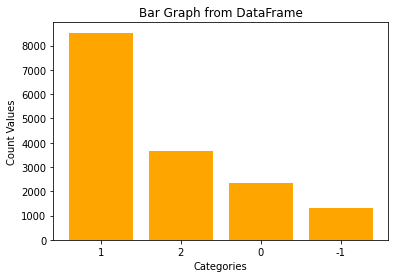

In [6]:
plt.bar(df_train['sentiment'].value_counts().index.astype('str'), df_train['sentiment'].value_counts(), color='orange')

plt.xlabel('Categories')
plt.ylabel('Count Values')
plt.title('Bar Graph from DataFrame')

# Display the plot
plt.show()

Looking at how many null values we have in our dataset and we derive that there is no null values

In [5]:
df_train.head()

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

In [13]:
import pandas as pd
import plotly.express as px

# Assuming 'text_column' is the column containing text data
text_data = ' '.join(df_train['message'].dropna())  # Combine all text into a single string

# Tokenize the text into words
words = text_data.split()

# Count the occurrences of each word
word_counts = pd.Series(words).value_counts()

# Create a DataFrame with word counts
df_word_counts = pd.DataFrame({'word': word_counts.index, 'count': word_counts.values})

# Create a treemap using plotly.express
fig = px.treemap(df_word_counts, path=['word'], values='count', title='Word Treemap')

# Show the interactive plot
fig.show()


In [6]:
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In order for us to understand the data I will print all the words in a wordcloud to figure out which 

# Data Pre-processsing

In [1]:
def preprocess_text(tweet):
    # Remove URLs, mentions, and special characters
    tweet = re.sub(r'http\S+|www\S+|@[^\s]+|\W|\d', ' ', tweet)
    # Tokenize
    tokens = word_tokenize(tweet.lower())
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Join words back into a sentence
    cleaned_tweet = ' '.join(tokens)
    return cleaned_tweet

df_train['cleaned_message'] = df_train['message'].apply(preprocess_text)

NameError: name 'df_train' is not defined

Looking at the effectof my data text pre processing step to see how much the data is getting cleaning but it seems like it is losing some data 

Display the cleaned data

In [8]:
df_train[['message', 'cleaned_message']].head()

message  \
0  PolySciMajor EPA chief doesn't think carbon di...   
1  It's not like we lack evidence of anthropogeni...   
2  RT @RawStory: Researchers say we have three ye...   
3  #TodayinMaker# WIRED : 2016 was a pivotal year...   
4  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   

                                     cleaned_message  
0  polyscimajor epa chief think carbon dioxide ma...  
1    like lack evidence anthropogenic global warming  
2  rt researchers say three years act climate cha...  
3  todayinmaker wired pivotal year war climate ch...  
4  rt racist sexist climate change denying bigot ...

# Building a model

In [15]:
# Create a list of models that I will use that we learnt in class
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC()
}

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_tfidf)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Print the results
    print(f"Model: {name}")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(class_report)
    print("-----")


Model: Multinomial Naive Bayes
Accuracy: 0.6487568478718921
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.02      0.05       401
           0       1.00      0.07      0.13       666
           1       0.62      0.98      0.76      2598
           2       0.84      0.44      0.58      1081

    accuracy                           0.65      4746
   macro avg       0.87      0.38      0.38      4746
weighted avg       0.75      0.65      0.57      4746

-----
Model: Random Forest
Accuracy: 0.6858407079646017
Classification Report:
              precision    recall  f1-score   support

          -1       0.85      0.22      0.35       401
           0       0.53      0.34      0.41       666
           1       0.69      0.88      0.77      2598
           2       0.73      0.60      0.66      1081

    accuracy                           0.69      4746
   macro avg       0.70      0.51      0.55      4746
weighted avg       0.69

C:\Users\Paul\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.7174462705436156
Classification Report:
              precision    recall  f1-score   support

          -1       0.81      0.26      0.40       401
           0       0.62      0.34      0.44       666
           1       0.71      0.91      0.80      2598
           2       0.76      0.66      0.71      1081

    accuracy                           0.72      4746
   macro avg       0.73      0.54      0.59      4746
weighted avg       0.72      0.72      0.69      4746

-----
Model: Support Vector Machine
Accuracy: 0.7176569742941424
Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.24      0.38       401
           0       0.72      0.26      0.38       666
           1       0.69      0.94      0.79      2598
           2       0.81      0.66      0.72      1081

    accuracy                           0.72      4746
   macro avg       0.79      0.52      0.57      4746
weighted avg      

In [ ]:
def main():
    return df

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train['cleaned_message'], df_train['sentiment'], test_size=0.2, random_state=42)

model = make_pipeline(
    CountVectorizer(),
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=1000)
)

# Use cross-validation to evaluate the model on mean F1 score
mean_f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print(f'Mean F1 Score: {mean_f1_scores.mean()}')

model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_valid)

# Evaluate the model on F1 score
f1 = f1_score(y_valid, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

# Optionally, print classification report for more detailed evaluation
print(classification_report(y_valid, y_pred))

C:\Users\Paul\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean F1 Score: 0.5532386157921005
F1 Score: 0.55
              precision    recall  f1-score   support

          -1       0.45      0.40      0.43       278
           0       0.35      0.40      0.37       425
           1       0.75      0.71      0.73      1755
           2       0.64      0.69      0.67       706

    accuracy                           0.64      3164
   macro avg       0.55      0.55      0.55      3164
weighted avg       0.65      0.64      0.64      3164



C:\Users\Paul\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Assuming X_fin represents the feature matrix and y_encoded represents the encoded sentiment labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_train['cleaned_message'], df_train['sentiment'], test_size=0.3, random_state=42)

# Create a list of models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC()
}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Print the results
    print(f"Model: {name}")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(class_report)
    print("-----")


ValueError: could not convert string to float: 'iran pakistan vow boost cooperation climate change'

In [23]:
df_test['cleaned_message'] = df_test['message'].apply(preprocess_text)
df_test['predicted_sentiment'] = model.predict(df_test['cleaned_message'])

# Create a DataFrame for the submission file
submission_df = pd.DataFrame({'tweetid': df_test['tweetid'], 'sentiment': df_test['predicted_sentiment']})

# Save the submission file to a CSV
submission_df.to_csv('submission_file.csv', index=False)

The model can perform better if the pre processing was a little better in understanding the words, there is room for improvement 